In [1]:
import sys
sys.path.append("../")

In [2]:
from torch.optim import Adam
import cv2
from scipy import interpolate
import scipy.interpolate as si

/data/shubham/tv_opt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn.functional as F
from colour.plotting import *
import numpy as np
import matplotlib.pyplot as plt
from datasets.cave_dataset import CAVEDataset


In [4]:
from datasets.cave_dataset import R

In [5]:
dataset = CAVEDataset("../datasets/data/CAVE", None, mode="train")

In [6]:
Rmodel = torch.nn.Linear(3, 31, bias=False)
model_path = "../artifacts/R.pt"
Rmodel.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
b = 6
g = 16
r = 25
# find 3 regions of peak response in spectral band no need of using the above peak bands. need to be data drive

In [7]:
def getControlPoints(knots, k):
    n = len(knots) - 1 - k
    cx = np.zeros(n)
    for i in range(n):
        tsum = 0
        for j in range(1, k+1):
            tsum += knots[i+j]
        cx[i] = float(tsum)/k
    return cx

In [8]:
class SplineBuilder:
    def __init__(self, x_, y_):
        self.x = x_
        self.y = y_
        self.xmin, self.xmax, self.ymin, self.ymax = None, None, None, None
        self.xmin, self.xmax = min(self.x), max(self.x) 
        self.ymin, self.ymax = min(self.y), max(self.y)
        self.n = len(self.x)
        self.knotspace = range(self.n)
        self.offset_x = (self.xmax - self.xmin)*0.05
        self.offset_y = (self.ymax - self.ymin)*0.1

    def get_spline(self, ):
        plotpoints = 100
        #####  PARAMETRIC SPLINE REPRESENTATION  #####
        k = 3
        # find knot vector 
        knots = si.InterpolatedUnivariateSpline(self.knotspace,self.knotspace,k=k).get_knots()
        self.knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))

        # define tuples of knot vector, coefficient vector (control points coordinates) and spline degree
        tckX = self.knots_full, self.x, k
        tckY = self.knots_full, self.y, k

        # construct spline functions
        splineX = si.UnivariateSpline._from_tck(tckX)
        splineY = si.UnivariateSpline._from_tck(tckY)

        # evaluate spline points
        self.tP = np.linspace(self.knotspace[0], self.knotspace[-1], plotpoints)
        self.xP = splineX(self.tP)
        self.yP = splineY(self.tP)
        # define coordinates of spline control points in knot space
        self.cp = getControlPoints(self.knots_full, k)
        self.knotpoints_y = [self.ymin-self.offset_y*0.5]*len(self.knots_full)
        self.knotpoints_x = [self.xmin-self.offset_x*0.5]*len(self.knots_full)

    def plot(self, ):
        fig = plt.figure()
        # ax = fig.add_subplot(224)
        # ax.grid(True)
        # plt.plot(self.x, self.cp, '-og')
        # plt.plot(self.xP, self.tP, 'r', lw=2)
        # plt.plot(self.knotpoints_x, self.knots_full, '>', ms=6, color='black')
        # plt.ylim([self.knotspace[0] - self.offset_y, self.knotspace[-1] + self.offset_y])
        # plt.xlim([self.xmin - self.offset_x, self.xmax + self.offset_x])
        # plt.ylabel('t', rotation=0,  labelpad=20, fontweight='bold', fontsize=14) # position=(1.0,0)
        # plt.xlabel('x', labelpad=10, fontweight='bold', fontsize=14) # position=(1.0,0)
        # ax.invert_yaxis()
        # plt.title('Spline function x(t)')

        # ax = fig.add_subplot(221)
        # ax.grid(True)
        # plt.plot(self.cp, self.y, '-og')
        # plt.plot(self.tP, self.yP, 'r', lw=2)
        # plt.plot(self.knots_full,self.knotpoints_y, '^', ms=6, color='black')
        # plt.xlim([self.knotspace[0] - self.offset_x, self.knotspace[-1] + self.offset_x])
        # plt.ylim([self.ymin - self.offset_y, self.ymax + self.offset_y])
        # plt.ylabel('y', labelpad=10, rotation=0, fontweight='bold', fontsize=14)
        # plt.xlabel('t', labelpad=20, fontweight='bold', fontsize=14)  #position=(0,0)
        # ax.invert_xaxis()
        # plt.title('Spline function y(t)')

        ax = fig.add_subplot(222)
        ax.grid(True)
        plt.plot(self.x, self.y, '-og')
        plt.plot(self.xP, self.yP, 'b', lw=2.5)
        plt.xlim([self.xmin - self.offset_x, self.xmax + self.offset_x])
        plt.ylim([self.ymin - self.offset_y, self.ymax + self.offset_y])
        plt.title('Spline curve f(x(t), y(t))')


In [40]:
y, z, x_gt, max_vals  = dataset[0]

In [17]:
y = y.permute(1, 2, 0).numpy()

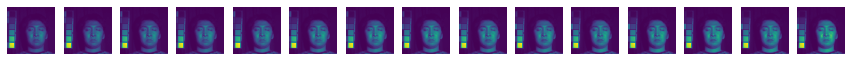

In [34]:
# 1st row all lrhsi bands as grayscale
fig, ax = plt.subplots(1, 15, figsize=(15,8))
for i in range(5, 20):
    ax[i-5].imshow(y[:, :, i])
    ax[i-5].axis("off")
    
# plt.tight_layout()

In [36]:
z = z.permute(1,2, 0).numpy()

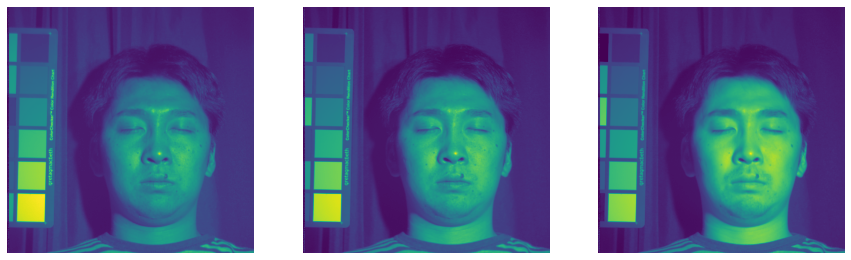

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15,8))
for i in range(3):
    ax[i].imshow(z[:, :, i])
    ax[i].axis("off")

In [38]:
x_gt.shape

torch.Size([31, 512, 512])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,8))
for i in range(3):
    ax[i].imshow(x[:, :, i])
    ax[i].axis("off")

In [11]:
pixel = 0

In [41]:
C, N1, N2 = z.shape
ZU = Rmodel(z.permute(1, 2, 0).reshape(-1, C)).reshape(N1, N2, -1).permute(2, 0, 1)

In [42]:
ZU.shape

torch.Size([31, 512, 512])

In [44]:
x_gt.shape

torch.Size([31, 512, 512])

In [ ]:
x_gt.shape

(-0.5, 511.5, 511.5, -0.5)

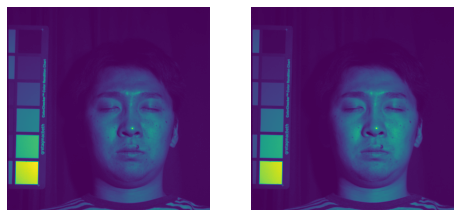

In [57]:
band = 5

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(x_gt[band, :, :].detach().numpy())
ax[0].axis("off")
ax[1].imshow(x_gt[band+5, :, :].detach().numpy())
ax[1].axis("off")    

In [13]:
x_ = torch.linspace(400, 700, 31)
y_ = ZU[:, 0, pixel]
rgb = z[:, 0, pixel]

x_, y_ = x_.detach().numpy(), y_.detach().numpy()

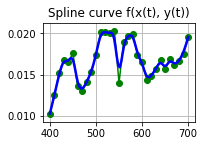

In [14]:
sp_zr = SplineBuilder(x_, y_)
sp_zr.get_spline()
sp_zr.plot()

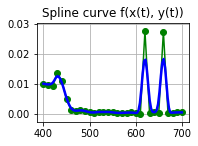

In [15]:
sp_zr_gt = SplineBuilder(x_, x_gt[:, 0, 0])
sp_zr_gt.get_spline()
sp_zr_gt.plot()

In [ ]:
# now lets try to update
sp_zr = SplineBuilder(x_, y_)
sp_zr.get_spline()
sp_zr.plot()

In [ ]:

x_ = torch.linspace(400, 700, 31)
C, N1, N2 = z.shape
ZU = Rmodel(z.permute(1, 2, 0).reshape(-1, C)).reshape(N1, N2, -1).permute(2, 0, 1)
y_ = ZU[:, 0, 0]
rgb = z[:, 0, 0]
x_, y_ = x_.detach().numpy(), y_.detach().numpy()

In [ ]:
# if you take gradients of a spline on this spectral response you can find peak points.
# now given critical points we can find closest to (450nm, 550nm, 650nm)

In [28]:
n_epochs = 50

In [14]:
model_path = "../artifacts/R.pt"

In [27]:
baseline_total = 0
# lets check mse loss for R provided by other vendors
for items in dataset:
    c, x_old, y, z, x_gt, lz, idx = items
    z_ipt = z.numpy()
    Zd = torch.zeros(z.shape[0], y.shape[1], y.shape[2])
    C, N1, N2 = Zd.shape
    for c in range(Zd.shape[0]):
        Zd[c, :, :] = torch.FloatTensor(cv2.resize(z_ipt[c, :, :], (N1, N2), interpolation=cv2.INTER_CUBIC))
    
    y_pred = (R.T @ Zd.reshape(C, -1)).reshape(y.shape[0], N1, N2)
    loss = mse(y_pred, y)
    baseline_total += loss.item()

print(baseline_total/len(dataset))

0.04466786754962344


In [47]:
print(baseline_total/len(dataset))

0.04466786754962344


In [52]:
model.train()
best_mse_loss = baseline_total/len(dataset)
for epoch in range(n_epochs):
    total_mse_loss = 0
    for items in dataset:
        optimizer.zero_grad()
        c, x_old, y, z, x_gt, lz, idx = items
        z_ipt = z.numpy()
        Zd = torch.zeros(z.shape[0], y.shape[1], y.shape[2])
        C, N1, N2 = Zd.shape
        for c in range(Zd.shape[0]):
            Zd[c, :, :] = torch.FloatTensor(cv2.resize(z_ipt[c, :, :], (N1, N2), interpolation=cv2.INTER_CUBIC))
        Zd = Zd.permute(1, 2, 0).reshape(-1, C)[None, ...]
        y_pred = model(Zd)
        # y_pred = (newR @ Zd.reshape(C, -1)).reshape(*y.shape)
        y_pred = y_pred.transpose(1, 2).reshape(1, y.shape[0], N1, N2)
        loss = mse(y_pred, y[None, ...])
        loss.backward()
        optimizer.step()
        total_mse_loss += loss.item()

    print(f"epoch {epoch} mse: {total_mse_loss/len(dataset)}")
    # if total_mse_loss/len(dataset) < best_mse_loss:
    #     best_mse_loss =  total_mse_loss/len(dataset)
    #     print("saving ...")
    #     torch.save(model.state_dict(), model_path)

epoch 0 mse: 0.0549600964698654
epoch 1 mse: 0.05061110012376538
epoch 2 mse: 0.04662693220262344
epoch 3 mse: 0.04302138054313568
epoch 4 mse: 0.03976119606970595
epoch 5 mse: 0.036813664536636606
epoch 6 mse: 0.03414908878935071
epoch 7 mse: 0.03174053650134458
epoch 8 mse: 0.02956353942863643
epoch 9 mse: 0.027595865880497374
epoch 10 mse: 0.025817318873193402
epoch 11 mse: 0.024209568223271232
epoch 12 mse: 0.022755993404783882
epoch 13 mse: 0.021441536131673135
epoch 14 mse: 0.020252572229275338
epoch 15 mse: 0.019176782878975455
epoch 16 mse: 0.018203041158043422
epoch 17 mse: 0.01732129970780359
epoch 18 mse: 0.0165224948611397
epoch 19 mse: 0.01579845159386213
epoch 20 mse: 0.015141800780279132
epoch 21 mse: 0.014545898938264985
epoch 22 mse: 0.014004757162183523
epoch 23 mse: 0.013512977237741534
epoch 24 mse: 0.013065693595518287
epoch 25 mse: 0.01265851823756328
epoch 26 mse: 0.012287493204124846
epoch 27 mse: 0.011949048986515174
epoch 28 mse: 0.011639963996668275
epoch 29 

In [53]:
torch.save(model.state_dict(), model_path)

In [9]:
# z should be converted to have 31 bands
y[:,0,0]

tensor([864.0564, 526.5782, 336.3699, 284.4187, 251.4844, 186.3748, 214.7948,
        203.3272, 310.8278, 326.6242, 238.5372, 262.8672, 188.4587, 243.5897,
        257.0776, 413.8622, 392.3787, 251.6243, 202.8402, 413.3468, 354.0082,
        410.7009, 391.6816, 463.2041, 323.3726, 373.5068, 298.7026, 258.7417,
        331.5312, 166.2900, 178.5420])

In [57]:
from models.metrics import (
    compare_mpsnr,
    compare_mssim,
    find_rmse,
    # compare_sam,
    compare_ergas
)
from torchmetrics import SpectralAngleMapper
from torchmetrics import ErrorRelativeGlobalDimensionlessSynthesis as ERGAS
sam = SpectralAngleMapper()
ergas = ERGAS(ratio=1/8)


/data/shubham/tv_opt/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpectralAngleMapper` will save all targets and predictions in the buffer. For large datasets, this may lead to a large memory footprint.
  warnings.warn(*args, **kwargs)
/data/shubham/tv_opt/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `UniversalImageQualityIndex` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [54]:
model.eval()

Linear(in_features=3, out_features=31, bias=False)

In [55]:
R = model.weight

In [56]:
R.shape

torch.Size([31, 3])

In [58]:
R @z.reshape(z)

torch.Size([3, 512, 512])

In [59]:
test_dataset = CAVEDataset("../datasets/data/CAVE", None, mode="test")
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        shuffle=False, batch_size=1)

In [60]:
sf = 8

In [62]:
# lets check all the metrics from the learned R


total_psnr, total_ssim, total_rmse, total_sam, total_ergas =0,0,0,0,0
with torch.no_grad():
    for items in test_dataset:
        c, x_old, y, z, x, lz, idx = items

        zc, N1, N2 = z.shape 
        x2 = (R @ z.reshape(zc, -1)).reshape(y.shape[0], N1, N2)
    
        x = x.squeeze()
        x2 = x2.squeeze()
        x = x.permute(1, 2, 0).detach().cpu().numpy()
        x2 = x2.permute(1, 2, 0).detach().cpu().numpy()
        
        total_ssim += compare_mssim(x, x2)
        rmse,  mse, rmse_per_band = find_rmse(x, x2)
        total_rmse += rmse
        total_psnr += compare_mpsnr(x, x2, mse)
        
        total_ergas += compare_ergas(x, x2, sf, rmse_per_band)
        # total_sam += compare_sam(x, x2)
        # total_ergas += ergas(torch.from_numpy(x).permute(2, 0, 1)[None, ...], 
        #                     torch.from_numpy(x2).permute(2, 0, 1)[None, ...])
        # total_ergas += compare_ergas(x, x2,1/sf, rmse_per_band)

opt = f"""## Metric scores:
psnr:{total_psnr/len(test_loader)},
ssim:{total_ssim/len(test_loader)},
rmse:{total_rmse/len(test_loader)},
sam:{total_sam/len(test_loader)},
ergas:{total_ergas/len(test_loader)},
"""
print(opt)

/data/shubham/HSI-MSI-Image-Fusion/hmi_fusion/notebooks/../models/hip/quality_metrics/cal_ssim.py:26: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


## Metric scores:
psnr:63.85741291840228,
ssim:0.9999998807907104,
rmse:0.1621954462527922,
sam:nan,
ergas:11.812759121426483,



In [13]:
z.shape

torch.Size([3, 512, 512])

In [19]:
z_ = R.T @ (z.reshape(3, -1)/255)

In [20]:
z_.min(), z_.max()

(tensor(0.), tensor(0.0245))

In [40]:
zm = z.reshape(3, -1)
z_ = R.T @ ((zm - zm.min(-1).values[:, None] / zm.max(-1).values[:, None]))
z_.min(), z_.max()

(tensor(0.), tensor(6.2440))

In [33]:
z_ = R.T @ (z.reshape(3, -1)/z.reshape(3, -1).max(1).values[:, None])
z_.min(), z_.max()

(tensor(0.), tensor(0.0319))

In [31]:
y_ = R @ (y.reshape(31, -1)/y.reshape(31, -1).max(1).values[:, None])

In [32]:

y_.min(), y_.max()

(tensor(0.0005), tensor(0.2005))

In [22]:
y_.min(), y_.max()

(tensor(0.0004), tensor(0.1726))

In [18]:
z_.min(), z_.max()

(tensor(0.), tensor(6.2440))

In [ ]:
# downsample 512, 512, 3 to 64, 64, 3

# def spectral_response_to_band(y, z):
    

In [10]:
# import pyspectral
# pyspectral.rsr_reader.RelativeSpectralResponse() # wavelength to band number calculation

In [ ]:
# we need to have dowsampling loss better than L2(downsample(z, bicubic))

